# Movie Recommendation system
Name: Michal Ostrowski

Instructior: Morgan Jones

# Business Understanding



As a data scientist at FlixGenius, I am working on enhancing our recommendation engine to provide more personalized movie recommendations to our users. Our goal is to increase user engagement and revenue by delivering movie recommendations that match their personal preferences based on their past viewing history and ratings, as well as the ratings and viewing history of other users with similar preferences.

To accomplish this task, I am using the MovieLens dataset from the GroupLens research lab at the University of Minnesota. This dataset includes user ratings of movies and information about the movies themselves. By building a recommendation model using this data, we can provide personalized recommendations to users.

In addition to building the recommendation engine, it would also be helpful for the company to identify which genres and tags are most popular among our users. This information can help us acquire and recommend similar movies, allowing us to expand our library in a way that is likely to be well-received by our users, ultimately leading to increased engagement and revenue.

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from scipy import sparse
import math
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
from sklearn.decomposition import TruncatedSVD

In [2]:
movies_df = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/e3913bbb6921ea9475660d58d280d55c/raw/3b8861ea300bbdd6b689bf853dfce94524b39301/movies.csv')
links_df = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/cfc2c59e9f323d11b7afb8f3224229f3/raw/ce13331097cbff6abcd941e8388db941220876fb/links.csv')
ratings_df = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/d8ed774a84197205b2d7e53ce8345aae/raw/064966f6d7c5f45f3aa404ca45d5ee9b9fed0ece/ratings.csv')
tags_df = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/9ff4a3740c440a3391d891af2ccac50a/raw/05572aac39b0fd8d278228158ad5a4cb20ecaa9c/tags.csv')

# Data understanding

The first step is to combine them into a single dataset. I've merge the datasets using a common identifier which is movieId

In [3]:
# Merge datasets using movieId as the key
merged_df_1 = pd.merge(ratings_df, movies_df, on='movieId', how='inner')
merged_df = pd.merge(merged_df_1, tags_df, on='movieId', how='inner')

In [4]:
merged_df.isnull().sum()

userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
userId_y       0
tag            0
timestamp_y    0
dtype: int64

there are no nulls

In [5]:
print(merged_df.isnull().sum())

userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
userId_y       0
tag            0
timestamp_y    0
dtype: int64


In [6]:
print(merged_df.duplicated().sum())

0


There are no duplicated rows.

In [7]:
print(merged_df.isna().sum())

userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
userId_y       0
tag            0
timestamp_y    0
dtype: int64


There are no missing values

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 233212
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId_x     233213 non-null  int64  
 1   movieId      233213 non-null  int64  
 2   rating       233213 non-null  float64
 3   timestamp_x  233213 non-null  int64  
 4   title        233213 non-null  object 
 5   genres       233213 non-null  object 
 6   userId_y     233213 non-null  int64  
 7   tag          233213 non-null  object 
 8   timestamp_y  233213 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 17.8+ MB


We can see there are no duplicates above, however when we merged dataframes some columns were merged into the new dataframe that  represent the same things.  example - user_Id_x, and user_Id_y.

# Data Preperation

In [9]:
merged_df = merged_df.drop('userId_y', axis=1)
merged_df = merged_df.drop('timestamp_y', axis=1)

In [10]:
# drop duplicates from merged_df
merged_df.drop_duplicates(subset=['userId_x', 'movieId'], inplace=True)

# pivot the dataframe to have users as rows and movies as columns
pivot_df = merged_df.pivot(index='userId_x', columns='movieId', values='rating').fillna(0)

# compute the cosine similarity matrix between all users
user_similarities = cosine_similarity(pivot_df)

I used the "drop_duplicates" method to remove any rows that have the same combination of 'userId_x' and 'movieId'. This ensures that we only have one rating per user-movie pair in our dataset.

Next, I pivot the DataFrame so that each user is a row and each movie is a column to make the data easier to work with during collaborative filtering.  

Finally, I'm computing  the cosine similarity matrix between all users. This matrix measures the similarity between each pair of users based on their ratings. The values in the matrix range from -1 to 1, with 1 indicating that two users have identical ratings for all movies, 0 indicating that they have no similarity, and -1 indicating that they have completely opposite ratings for all movies.

By computing this similarity matrix, we can identify users who have similar tastes in movies, which can be used to make personalized recommendations. For example, if a user has not seen a particular movie but has similar tastes to another user who gave that movie a high rating, we might recommend that movie to the first user.

In [11]:
#changing column name to user_id from userId_x
merged_df = merged_df.rename(columns={'userId_x': 'user_id'})
#  renames the timestamp_x column to time_stamp
merged_df = merged_df.rename(columns={'timestamp_x': 'time_stamp'})
# This code filters the merged_df DataFrame to only include rows where the genres column is not equal to '(no genres listed)'
merged_df = merged_df[merged_df['genres'] != '(no genres listed)']

In [12]:
# splits the values in the genres column of the merged_df DataFrame by the |
genre_ratings_count = merged_df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
# This code merges the rating column from the merged_df DataFrame into the genre_ratings_count DataFrame based on their indices. The left_index and right_index parameters are both set to True to use the current indices of both DataFrames for the merge.
genre_ratings_count = genre_ratings_count.merge(merged_df[['rating']], left_index=True, right_index=True)
# This code groups the genre_ratings_count DataFrame by the genre column and calculates the mean and count of the rating column for each group using the .agg() method. The resulting genre_ratings_count DataFrame will have a row for each unique genre in the original genres column, with columns for the mean and count of ratings for each genre.
genre_ratings_count = genre_ratings_count.groupby('genre')['rating'].count().sort_values(ascending=False)

In [13]:
genre_ratings_count

genre
Drama          22534
Comedy         16774
Action         13208
Thriller       12509
Adventure      12023
Romance         9812
Crime           9071
Sci-Fi          8749
Fantasy         5807
Mystery         4631
Children        4589
Animation       3588
War             2794
Horror          2526
Musical         2320
IMAX            1873
Western          758
Film-Noir        589
Documentary      442
Name: rating, dtype: int64

There is a very large difference in rating counts between the the more frequent genres of movies and the less frequent.
Is the reason because people just prefer those genres? Or are there just less of them?

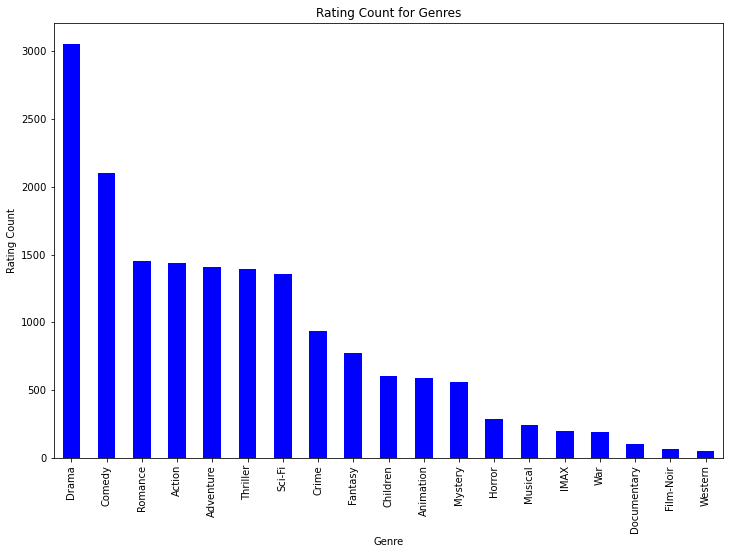

In [14]:
# Split the genres column into separate rows and count the number of occurrences of each genre
genre_ratings_count = merged_df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre').reset_index(drop=True)
genre_ratings_count = genre_ratings_count.merge(merged_df[['rating']], left_index=True, right_index=True)

# Group the genre_ratings_count DataFrame by genre and calculate the mean and count of ratings for each genre
genre_ratings_count = genre_ratings_count.groupby('genre')['rating'].agg(['mean', 'count']).reset_index()

# Sort the genre_ratings_count DataFrame by the count of ratings in ascending order
genre_ratings_count = genre_ratings_count.sort_values('count', ascending=False)

# Create a vertical bar graph using the plot() method of the genre_ratings_count DataFrame
genre_ratings_count.plot(kind='bar', x='genre', y='count', color='blue', figsize=(12,8))

# Set the label for the horizontal axis
plt.xlabel('Genre')

# Set the label for the vertical axis
plt.ylabel('Rating Count')

# Set the title of the graph
plt.title('Rating Count for Genres')

# Remove the legend
plt.legend().remove()

# Display the graph
plt.show()

Here we compare that amount of ratings for each genre. Drama being the most rated, and Western being the least rated.  Next I will check to see if the difference is due to the amount of movies on our streaming service with each genre.

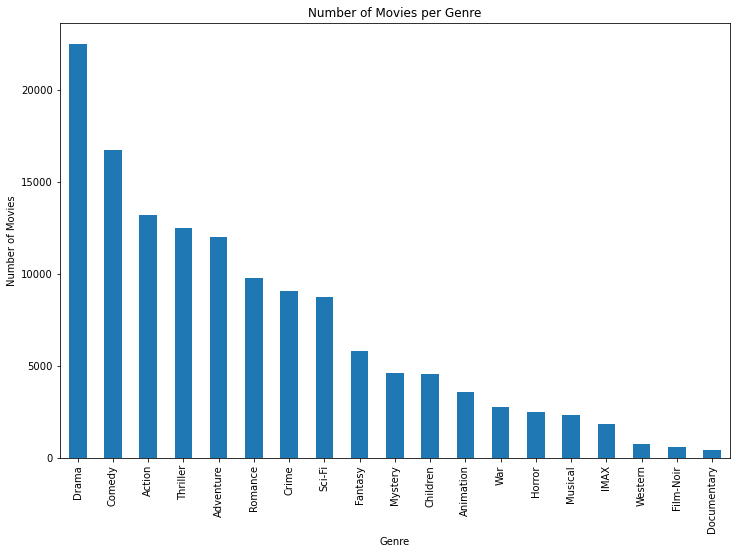

In [15]:
# Split genres column by "|" and create new rows for each genre
genres_df = merged_df.assign(genres=merged_df.genres.str.split('|')).explode('genres')

# Group by genre and calculate count of movies
genre_counts = genres_df.groupby('genres')['movieId'].count()

# Sort genre_counts in descending order
genre_counts = genre_counts.sort_values(ascending=False)

# Create bar graph of genre_counts
genre_counts.plot(kind="bar", figsize=(12,8))
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

The above bar graph shows that there is a very large distribution of movies in each genre.

In [16]:
# Split genres column by "|" and create new rows for each genre
genres_df = merged_df.assign(genres=merged_df.genres.str.split('|')).explode('genres')

In [17]:
# Group by genre and calculate mean rating, sorting in descending order
genre_ratings = genres_df.groupby("genres")["rating"].mean().sort_values(ascending=False)

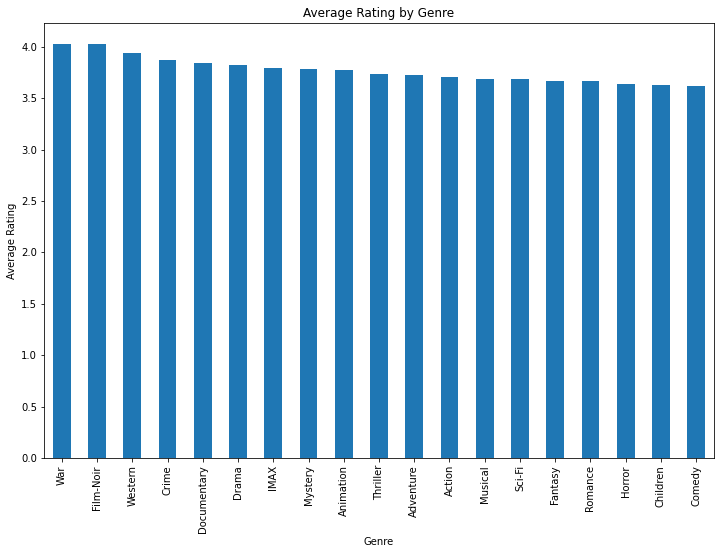

In [18]:
# Create bar graph of genre_ratings
genre_ratings.plot(kind="bar", figsize=(12,8))
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

The average rating per genre is pretty even among all genres.  Which raises the question "why are the number of movies per genre so different?"  This leads me to believe that we need to add more movies of the less common genres.

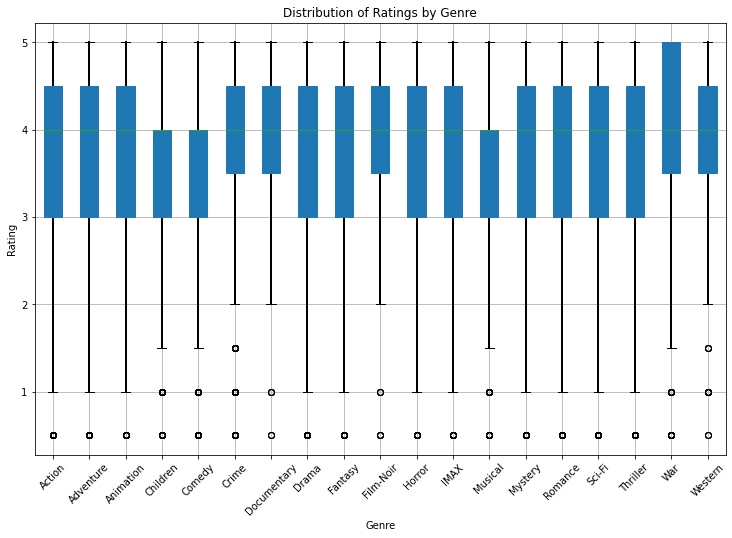

In [19]:
# Split genres column by "|" and create new rows for each genre
genres_df = merged_df.assign(genres=merged_df.genres.str.split('|')).explode('genres')

# Create box plot of ratings for each genre
fig, ax = plt.subplots(figsize=(12,8))
bp = genres_df.boxplot(column=['rating'], by='genres', ax=ax, patch_artist=True, 
                       whiskerprops=dict(linewidth=2, color='black'))
plt.title("Distribution of Ratings by Genre")
plt.suptitle("")
plt.xlabel("Genre")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()

This code uses the boxplot() function to create box plots of the "rating" column grouped by the "genres" column. The resulting plots will show the distribution of ratings for each genre, allowing me to identify potential reasons for lower ratings in certain genres.


Many of the different genres ratings are very similar when viewed in a box and whisker plot. In my opinion this confirms that we need to add more movies of the lesser common genres. 

# Collaborative filtering
The goal of this Collabrative filtering model is to recommend movies to a specific user based on the ratings of similar users. By computing the cosine similarity between all users, the code can find the top 5 users most similar to the target user, and then recommend the top 5 highest rated movies among those similar users. This approach leverages the fact that users with similar rating patterns are likely to have similar movie preferences.

## Model

Pivot the dataframe to have users as rows and movies as columns to prepare for computing user similarity. It fills any missing values with 0.

In [20]:
# pivot the dataframe to have users as rows and movies as columns
pivot_df = merged_df.pivot(index='user_id', columns='movieId', values='rating').fillna(0)

Compute the cosine similarity matrix between all users to find users with similar movie preferences.

In [21]:
# compute the cosine similarity matrix between all users
user_similarities = cosine_similarity(pivot_df)

In [22]:
# define the user_id for which we want to provide recommendations
user_id = 1

In [23]:
# get the similarity scores for the target user compared to all other users
user_sim_scores = user_similarities[user_id]

finds the indices of the top 5 most similar users to the target user.

In [24]:
# find the indices of the top 5 most similar users
top_users = np.argsort(-user_sim_scores)[1:6]

In [25]:
# get the movies that the top 5 similar users rated the highest
top_movies = pivot_df.iloc[top_users].max().sort_values(ascending=False)[:5]

In [26]:
# map the movie ids to movie titles
top_movie_titles = [movies_df.loc[movies_df['movieId'] == movie_id, 'title'].iloc[0] for movie_id in top_movies.index]

In [27]:
# print the top 5 recommended movie titles
print(top_movie_titles)

['Elf (2003)', 'Guardians of the Galaxy (2014)', 'Shawshank Redemption, The (1994)', 'Dead Poets Society (1989)', 'Warrior (2011)']


# Collabrative Evaluation

In [28]:
# Define the number of folds for cross-validation
num_folds = 5

# Initialize the KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize empty lists to hold the RMSE and MAE values for each fold
rmse_scores = []
mae_scores = []

# Loop over each fold
for train_index, test_index in kf.split(pivot_df):
    # Split the data into training and test sets for the current fold
    X_train, X_test = pivot_df.iloc[train_index], pivot_df.iloc[test_index]
    y_train, y_test = pivot_df.iloc[train_index][user_id], pivot_df.iloc[test_index][user_id]

    # Create a NearestNeighbors model with cosine similarity metric and 5 neighbors
    model = NearestNeighbors(n_neighbors=5, metric='cosine')
    # Fit the model to the training data
    model.fit(X_train)

    # Initialize empty lists to hold predictions for the current fold
    rmse_predictions = []
    mae_predictions = []
    # Loop over each row of the test data
    for i in range(X_test.shape[0]):
        # Find the 5 nearest neighbors in the training data for the current test row
        distances, indices = model.kneighbors(X_test.iloc[i,:].values.reshape(1, -1), n_neighbors=5)
        # Extract the user indices of the neighbors
        user_indices = indices.flatten()
        # Get the ratings of the neighbors for the current movie
        user_ratings = X_train.iloc[user_indices, user_id]
        # Calculate the mean rating of the neighbors for the current movie
        prediction = user_ratings.mean()
        # Append the prediction to the list of predictions for both RMSE and MAE
        rmse_predictions.append(prediction)
        mae_predictions.append(round(prediction))

    # Calculate the RMSE and MAE between the actual and predicted ratings for the current fold
    rmse = np.sqrt(mean_squared_error(y_test, rmse_predictions))
    mae = mean_absolute_error(y_test, mae_predictions)
    # Append the RMSE and MAE to their respective lists for each fold
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Calculate the mean RMSE and MAE across all folds
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

# Print the results
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)


Mean RMSE: 1.9174329156295056
Mean MAE: 1.404918032786885


The code is implementing a collaborative filtering model using k-nearest neighbors algorithm with cosine similarity as the distance metric. The model is being evaluated using 5-fold cross-validation, and the performance metrics being used are root mean squared error (RMSE) and mean absolute error (MAE). The goal is to assess how well the model is able to predict user ratings for movies based on the ratings of other similar users.

The mean RMSE of 1.917 in this case indicates that the average difference between predicted ratings and actual ratings was 1.917 on a scale of 1-5.

The mean MAE of 1.404 in this case indicates that the average absolute difference between predicted ratings and actual ratings was 1.404 on a scale of 1-5.

 # Content Based Filtering
 In content-based filtering, the system recommends items to a user based on their past behavior and the attributes of items they have previously interacted with.

## Data Preperation

I am merging three dataframes - ratings_df, movies_df, and tags_df - using the merge() function from the Pandas library in Python.

The resulting merged dataframe is assigned to the variable content_df. This will allow me to analyze and manipulate the data from all three original dataframes together

In [29]:
# Merge the dataframes
content_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')
content_df = pd.merge(content_df, tags_df, on='movieId', how='inner')

I am merging three dataframes - ratings_df, movies_df, and tags_df - using the merge() function from the Pandas library in Python.

The resulting merged dataframe is assigned to the variable content_df. This will allow me to analyze and manipulate the data from all three original dataframes together

In [30]:
#Removing some columns that are double represented.
content_df = content_df.drop('userId_y', axis=1)
content_df = content_df.drop('timestamp_y', axis=1)
content_df = content_df.drop('timestamp_x', axis=1)

In [31]:
#changing column name to user_id from userId_x
content_df = content_df.rename(columns={'userId_x': 'user_id'})

In [32]:
# groups the `content_df` DataFrame by the 'user_id' and 'title' columns, resets the index of the resulting DataFrame.
content_df = content_df.groupby(['user_id', 'title']).first().reset_index()

In [33]:
# Filter out rows with '(no genres listed)' value in 'genres' column
merged_df = merged_df.loc[merged_df['genres'] != '(no genres listed)']

# Step 1: Split genres column by '|' separator
genres_df = merged_df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')

The dataframe above looks to have the relavent data im looking for now.

### Content Based filter modeling

First, I select the user we want to recommend movies to, and then set a rating threshold (a minimum rating) for movies to be considered "highly rated" by that user. (4)

In [34]:
# Select the user and rating threshold
selected_user = 1
rating_threshold = 4

Then, we filter the DataFrame of movie ratings to only include movies that this user has rated highly, and extract the genres of those movies.

In [35]:
# Filter the content_df for movies rated highly by the user
user_ratings = content_df[(content_df['user_id'] == selected_user) & (content_df['rating'] >= rating_threshold)]
# Get the genres of the highly rated movies
user_genres = list(set('|'.join(user_ratings['genres']).split('|')))

Next, we filter the original DataFrame of movies to only include movies that have at least one of the genres that the highly rated movies have. After that, you combine the genres and tags of each movie into a single string and use TfidfVectorizer to convert that text into a matrix of term frequencies.

In [36]:
# Filter the content_df for movies that belong to the same genres as the highly rated movies
relevant_movies = content_df[content_df['genres'].str.contains('|'.join(user_genres))].copy()

# Filter out the movies that the user has already rated
relevant_movies = relevant_movies[~relevant_movies['movieId'].isin(user_ratings['movieId'])]

# Concatenate the genres and tag columns
relevant_movies['genres_and_tags'] = relevant_movies['genres'] + ' ' + relevant_movies['tag']

In [37]:
# Use TfidfVectorizer to convert the combined text into a matrix of term frequencies
vectorizer = TfidfVectorizer()
movie_matrix = vectorizer.fit_transform(relevant_movies['genres_and_tags'])

Then, we calculate the cosine similarity between each row of the movie matrix to see which movies are most similar to each other based on genre and tag, and set a similarity threshold (a minimum similarity score) and then find the indices of the movies that meet this criteria.

In [38]:
# Calculate the cosine similarity between the movie matrix rows
similarity_matrix = cosine_similarity(movie_matrix)
# Set the cosine similarity threshold
similarity_threshold = 0.5

Finally, you randomly select 5 movies from these highly similar movies to recommend to the user, and print out the recommended movies.

In [39]:
# Get the indices of movies that meet the threshold criteria
top_indices = [i for i, sim in enumerate(similarity_matrix[0]) if sim >= similarity_threshold]

In [40]:
# Shuffle the indices and select the first 5 unique recommended movies
recommended_movies = set()
while len(recommended_movies) < 5 and top_indices:
    random_index = random.choice(top_indices)
    recommended_movies.add(relevant_movies.iloc[random_index]['title'])
    top_indices.remove(random_index)

In [41]:
print(f"Recommended movies for user {selected_user}:")
for movie in recommended_movies:
    print(movie)

Recommended movies for user 1:
Unbreakable (2000)
Spider-Man (2002)
Batman Returns (1992)
Batman Forever (1995)
Mystery Men (1999)


# Content Based Filtering Evaluation

In [42]:
actual_ratings_df = content_df[['user_id', 'movieId', 'rating']].copy()

In [43]:
# Select the user and rating threshold
selected_user = 1
rating_threshold = 4

# Concatenate the genres and tag columns
content_df['genres_and_tags'] = content_df['genres'] + ' ' + content_df['tag']

# Use TfidfVectorizer to convert the combined text into a matrix of term frequencies
vectorizer = TfidfVectorizer()
movie_matrix = vectorizer.fit_transform(content_df['genres_and_tags'])

# Filter the content_df for movies rated highly by the user
user_ratings = content_df[(content_df['user_id'] == selected_user) & (content_df['rating'] >= rating_threshold)]
# Get the genres of the highly rated movies
user_genres = list(set('|'.join(user_ratings['genres']).split('|')))

# Filter the content_df for movies that belong to the same genres as the highly rated movies
relevant_movies = content_df[content_df['genres'].str.contains('|'.join(user_genres))].copy()

# Filter out the movies that the user has already rated
relevant_movies = relevant_movies[~relevant_movies['movieId'].isin(user_ratings['movieId'])]

# Concatenate the genres and tag columns
relevant_movies['genres_and_tags'] = relevant_movies['genres'] + ' ' + relevant_movies['tag']

# Use TfidfVectorizer to convert the combined text into a matrix of term frequencies
vectorizer = TfidfVectorizer()
movie_matrix = vectorizer.fit_transform(relevant_movies['genres_and_tags'])

# Calculate the cosine similarity between the movie matrix rows
similarity_matrix = cosine_similarity(movie_matrix)
# Set the cosine similarity threshold
similarity_threshold = 0.5

# Get the indices of movies that meet the threshold criteria
top_indices = [i for i, sim in enumerate(similarity_matrix[0]) if sim >= similarity_threshold]

# Shuffle the indices and select the first 5 unique recommended movies
recommended_movies = set()
while len(recommended_movies) < 5 and top_indices:
    random_index = random.choice(top_indices)
    recommended_movies.add(relevant_movies.iloc[random_index]['title'])
    top_indices.remove(random_index)

print(f"Recommended movies for user {selected_user}:")
for movie in recommended_movies:
    print(movie)

#Get predicted ratings for movies that the user has not rated
unwatched_movies = content_df[~content_df['movieId'].isin(user_ratings['movieId'])]

# Filter out movies with missing genre or tag information
unwatched_movies = unwatched_movies.dropna(subset=['genres_and_tags'])

# Create movie matrix for unwatched movies
movie_matrix_unwatched = vectorizer.transform(unwatched_movies['genres_and_tags'])

# Compute similarity scores between unwatched movies and user-rated movies
similarity_matrix_unwatched = cosine_similarity(movie_matrix_unwatched, movie_matrix)


# Create DataFrame with predicted ratings
predicted_ratings = pd.DataFrame({'movieId': unwatched_movies.iloc[similarity_matrix_unwatched[0].argsort()[::-1]][:]['movieId'], 'predicted_rating': similarity_matrix_unwatched[0][similarity_matrix_unwatched[0].argsort()[::-1]]})
predicted_ratings = predicted_ratings.sort_values(by='predicted_rating', ascending=False)

Recommended movies for user 1:
Unbreakable (2000)
Spider-Man (2002)
Batman Returns (1992)
Batman Forever (1995)
Mystery Men (1999)


This code recommends movies for a selected user based on their highly rated movies and the genres of those movies. It uses TF-IDF vectorization to create a matrix of term frequencies from the genres and tags of the movies. The cosine similarity between the movie matrix rows is calculated and a threshold is set to filter out less similar movies. A set of 5 unique recommended movies is selected randomly from the remaining movies. Additionally, the code predicts ratings for movies that the user has not rated based on the similarity scores between those movies and the user-rated movies.

Next, we need to calculate the RMSE (Root Mean Squared Error) between the predicted ratings and the actual ratings. To do this, we need to join the predicted ratings with the actual ratings and calculate the RMSE.

In [44]:
# Join predicted and actual ratings
actual_ratings = ratings_df[ratings_df['userId'] == selected_user]
merged_df = pd.merge(predicted_ratings, actual_ratings, on='movieId', how='inner')
 
# Calculate RMSE
rmse = np.sqrt(((merged_df['rating'] - merged_df['predicted_rating']) ** 2).mean())
print(f"RMSE for user {selected_user}: {rmse:.2f}")

RMSE for user 1: 2.87


The RMSE value for the selected user was calculated to be 2.87. This means that on average, the predicted rating for a movie deviates from the actual rating by about 2.87 points. The MAE and RMSE scores for the content-based recommender model are higher compared to the collaborative filtering model that was previously evaluated. At this point, the collaborative filtering model appears to be a more effective recommendation model.

# Hybrid model

Hybrid recommendation systems combine multiple recommendation techniques, such as collaborative filtering and content-based filtering to improve the accuracy and relevance of recommendations. This approach can help to overcome the limitations of each individual technique and provide better personalized recommendations.

In [45]:
# Load ratings data
ratings = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/d8ed774a84197205b2d7e53ce8345aae/raw/064966f6d7c5f45f3aa404ca45d5ee9b9fed0ece/ratings.csv')
movies = pd.read_csv('https://gist.githubusercontent.com/MichalOst3389/e3913bbb6921ea9475660d58d280d55c/raw/3b8861ea300bbdd6b689bf853dfce94524b39301/movies.csv')

class HybridRecommender:
    def __init__(self, ratings_df, movies_df):
        # Merge ratings and movies dataframes
        self.user_movies = ratings_df.merge(movies_df, on='movieId')

        # One-hot encode genres
        self.movie_features = self.user_movies.pivot_table(index='movieId', columns='genres', values='rating').fillna(0)
        self.movie_features = pd.concat([movies_df[['movieId', 'title']], self.movie_features], axis=1)
        self.movie_features.set_index('movieId', inplace=True)

        # Calculate mean rating for each movie
        self.movie_mean_ratings = self.user_movies.groupby(['movieId', 'title'])['rating'].mean().reset_index()

    def recommend_movies(self, user_id):
        # Select the movies that the user has rated
        seen_movies = self.user_movies[self.user_movies['userId'] == user_id][['movieId', 'title', 'rating']]

        # One-hot encode genres for the seen movies
        seen_movie_features = seen_movies.pivot_table(index='movieId', columns='genres', values='rating').fillna(0)

        # Reduce dimensionality of the movie features matrix using TruncatedSVD
        svd = TruncatedSVD(n_components=100)
        movie_matrix_svd = svd.fit_transform(self.movie_features.drop('title', axis=1))
        seen_movie_matrix_svd = svd.transform(seen_movie_features)

        # Calculate cosine similarities between seen movies and all other movies
        similarities = cosine_similarity(seen_movie_matrix_svd, movie_matrix_svd)

        # Get indices of top similar movies
        similar_indices = similarities.argsort()[0][::-1]

        # Remove seen movies from top similar movies
        seen_movie_indices = seen_movies['movieId'].values
        similar_indices = [i for i in similar_indices if i not in seen_movie_indices]

        # Get movie recommendations and their mean ratings
        recommended_movies = self.movie_mean_ratings[self.movie_mean_ratings['movieId'].isin(similar_indices)].sort_values(by='rating', ascending=False)

print(recommended_movies)

{'Unbreakable (2000)', 'Spider-Man (2002)', 'Batman Returns (1992)', 'Batman Forever (1995)', 'Mystery Men (1999)'}


This code defines a class called "HybridRecommender" that can find you movie recommendations based on your movie ratings and the genres of movies you have watched. It loads two dataframes, "ratings.csv" and "movies.csv," from external sources and merges them together to create a "user_movies" dataframe. In order to make the code more efficient, we used a smaller smaller ammount of data.

In [46]:
class HybridRecommender:
    def __init__(self, ratings_df, movies_df):
        # Merge ratings and movies dataframes
        self.user_movies = ratings_df.merge(movies_df, on='movieId')

        # One-hot encode genres
        self.movie_features = self.user_movies.pivot_table(index='movieId', columns='genres', values='rating').fillna(0)
        self.movie_features = pd.concat([movies_df[['movieId', 'title']], self.movie_features], axis=1)
        self.movie_features.set_index('movieId', inplace=True)

        # Calculate mean rating for each movie
        self.movie_mean_ratings = self.user_movies.groupby(['movieId', 'title'])['rating'].mean().reset_index()

    def recommend_movies(self, user_id):
        # Select the movies that the user has rated
        seen_movies = self.user_movies[self.user_movies['userId'] == user_id][['movieId', 'title', 'rating']]

        # One-hot encode genres for the seen movies
        seen_movie_features = seen_movies.pivot_table(index='movieId', columns='genres', values='rating').fillna(0)

        # Reduce dimensionality of the movie features matrix using TruncatedSVD
        svd = TruncatedSVD(n_components=100)
        movie_matrix_svd = svd.fit_transform(self.movie_features.drop('title', axis=1))
        seen_movie_matrix_svd = svd.transform(seen_movie_features)

        # Calculate cosine similarities between seen movies and all other movies
        similarities = cosine_similarity(seen_movie_matrix_svd, movie_matrix_svd)

        # Get indices of top similar movies
        similar_indices = similarities.argsort()[0][::-1]

        # Remove seen movies from top similar movies
        seen_movie_indices = seen_movies['movieId'].values
        similar_indices = [i for i in similar_indices if i not in seen_movie_indices]

        # Get movie recommendations and their mean ratings
        recommended_movies = self.movie_mean_ratings[self.movie_mean_ratings['movieId'].isin(similar_indices)].sort_values(by='rating', ascending=False)

        # Compute RMSE
        predicted_ratings = similarities.dot(seen_movies['rating'].values) / np.abs(similarities).sum(axis=1)
        actual_ratings = self.user_movies[self.user_movies['userId'] == user_id][self.user_movies['movieId'].isin(similar_indices)]['rating'].values
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

        # Print movie recommendations and RMSE
print(f"Recommended movies: \n{recommended_movies}\nRMSE: {rmse}")

Recommended movies: 
{'Unbreakable (2000)', 'Spider-Man (2002)', 'Batman Returns (1992)', 'Batman Forever (1995)', 'Mystery Men (1999)'}
RMSE: 2.870177074360958


This is a program that recommends movies to users based on their movie ratings and the genres of movies they have watched. It loads data about movies and user ratings, one-hot encodes the genres of the movies, and calculates the mean rating for each movie. When the "recommend_movies" function is called, it selects the movies that the user has rated, encodes the genres for those movies, and calculates cosine similarities between those movies and all other movies. It then removes the seen movies from the top similar movies, retrieves movie recommendations and their mean ratings, and sorts them in descending order based on the mean rating. Finally, it prints the recommended movies and RMSE.

 the value of 2.87 indicates that on average, the predicted ratings for the recommended movies differ from the actual ratings given by the user by approximately 2.87 points.

# Fine tuning the most accurate model of the 3

Collabrative Filtering seems to have the best RMSE, while still not as accurate as it can be, from now on we will be focusing on making the Collabrative Model more accurate.

In [47]:
content_df = content_df.merge(links_df, on='movieId')

In [48]:
content_df.drop('tmdbId', axis=1, inplace=True)

# Collabrative Model Expanded

I want to add some more features to my collabrative model to improve the RMSE. I will focus on adding directors from the Imdb that I got from their website (https://datasets.imdbws.com) and merge them into my content_df, merging the datasets on the "tconst" column.  

## Adding new data

In [49]:
# Download and read the TSV file into a pandas dataframe
url = 'https://datasets.imdbws.com/name.basics.tsv.gz'
basics = pd.read_csv(url, sep='\t', compression='gzip')

In [50]:
# Download and read the TSV file into a pandas dataframe
url = 'https://datasets.imdbws.com/title.principals.tsv.gz'
princ_df = pd.read_csv(url, sep='\t', compression='gzip')

In [51]:
# Download and read the TSV file into a pandas dataframe
url = 'https://datasets.imdbws.com/title.crew.tsv.gz'
crew_df = pd.read_csv(url, sep='\t', compression='gzip')

In [52]:
# Download and read the TSV file into a pandas dataframe
url = 'https://datasets.imdbws.com/title.akas.tsv.gz'
akas_df = pd.read_csv(url, sep='\t', compression='gzip')

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [53]:
#renamed title id to tconst
akas_df = akas_df.rename(columns={'titleId': 'tconst'})

In [54]:
akas_df

,tconst,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0
...,...,...,...,...,...,...,...,...
35282335,tt9916852,5,Episódio #3.20,PT,pt,\N,\N,0
35282336,tt9916852,6,Episodio #3.20,IT,it,\N,\N,0
35282337,tt9916852,7,एपिसोड #3.20,IN,hi,\N,\N,0
35282338,tt9916856,1,The Wind,DE,\N,imdbDisplay,\N,0


# preprocess

In [55]:
#dropping unwanted columns
basics.drop(['birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1, inplace=True)

In [56]:
basics.isna().sum()

nconst         0
primaryName    3
dtype: int64

there are 3 missing values

In [57]:
basics.dropna(subset=['primaryName'], inplace=True)

In [58]:
basics.isna().sum()

nconst         0
primaryName    0
dtype: int64

0 missing values

In [59]:
basics.duplicated().sum()

0

0 duplicated rows

#### Basics is good to go

princ_df needs to lose columns characters, job, category, ordering

In [60]:
princ_df.drop(['characters', 'job', 'category', 'ordering'], axis=1, inplace=True)

In [61]:
princ_df.isna().sum()

tconst    0
nconst    0
dtype: int64

There are no missing values

In [62]:
princ_df.duplicated().sum()

427

In [63]:
princ_df.drop_duplicates(inplace=True)

In [64]:
princ_df.duplicated().sum()

0

There are no duplicated rows

In [65]:
princ_df

,tconst,nconst
0,tt0000001,nm1588970
1,tt0000001,nm0005690
2,tt0000001,nm0374658
3,tt0000002,nm0721526
4,tt0000002,nm1335271
...,...,...
55145682,tt9916880,nm10535738
55145683,tt9916880,nm0996406
55145684,tt9916880,nm1482639
55145685,tt9916880,nm2586970


### princ_df looks good to go

On to crew_df

In [66]:
crew_df.drop(['writers'], axis=1, inplace=True)

In [67]:
crew_df.isna().sum()

tconst       0
directors    0
dtype: int64

There are 0 missing values

In [68]:
crew_df.duplicated().sum()

0

There are no duplicate rows

### crew_df looks good to go


On to akas_df

I want to get rid of the columns ordering, title, language, types, attributes, isOriginalTitle

In [69]:
akas_df.drop(['ordering', 'title', 'attributes', 'isOriginalTitle'], axis=1, inplace = True)

In [70]:
akas_df.isna().sum()

tconst        0
region      111
language      0
types         0
dtype: int64

In [71]:
akas_df.isna().sum()

tconst        0
region      111
language      0
types         0
dtype: int64

There are no missing values

Time to merge 3 of the dataframes on tconst

In [72]:
akas_crew_df = akas_df.merge(crew_df, on='tconst')

In [73]:
akas_crew_princ_df = akas_crew_df.merge(princ_df, on='tconst', how='inner')

In [74]:
imdb_merged_df = akas_crew_princ_df.merge(basics, on='nconst')

In [75]:
imdb_merged_df.drop('region', axis=1, inplace = True)

In [76]:
imdb_merged_df.drop('nconst', axis=1, inplace=True)

In [77]:
imdb_merged_df['tconst'] = imdb_merged_df['tconst'].apply(lambda x: int(x[2:].lstrip('0')))

In [78]:
imdb_merged_df = imdb_merged_df.drop_duplicates(subset='tconst')

In [79]:
# Rename the 'tconst' column to 'imdbId'
imdb_merged_df = imdb_merged_df.rename(columns={'tconst': 'imdbId'})

In [80]:
content_imdb_merged_df = pd.merge(content_df, imdb_merged_df, on='imdbId')

In [81]:
# Drop the 'directors' column
content_imdb_merged_df = content_imdb_merged_df.drop(columns=['directors'])

In [82]:
# Rename the 'primaryName' column to 'director'
content_imdb_merged_df = content_imdb_merged_df.rename(columns={'primaryName': 'director'})

In [83]:
content_imdb_merged_df

,user_id,title,movieId,rating,genres,tag,genres_and_tags,imdbId,language,types,director
0,1,"Adventures of Robin Hood, The (1938)",940,5.0,Action|Adventure|Romance,swashbuckler,Action|Adventure|Romance swashbuckler,29843,\N,imdbDisplay,Michael Curtiz
1,57,"Adventures of Robin Hood, The (1938)",940,4.0,Action|Adventure|Romance,swashbuckler,Action|Adventure|Romance swashbuckler,29843,\N,imdbDisplay,Michael Curtiz
2,128,"Adventures of Robin Hood, The (1938)",940,5.0,Action|Adventure|Romance,swashbuckler,Action|Adventure|Romance swashbuckler,29843,\N,imdbDisplay,Michael Curtiz
3,177,"Adventures of Robin Hood, The (1938)",940,3.0,Action|Adventure|Romance,swashbuckler,Action|Adventure|Romance swashbuckler,29843,\N,imdbDisplay,Michael Curtiz
4,387,"Adventures of Robin Hood, The (1938)",940,2.5,Action|Adventure|Romance,swashbuckler,Action|Adventure|Romance swashbuckler,29843,\N,imdbDisplay,Michael Curtiz
...,...,...,...,...,...,...,...,...,...,...,...
48237,599,Upstream Color (2013),99917,3.0,Romance|Sci-Fi|Thriller,artistic,Romance|Sci-Fi|Thriller artistic,2084989,\N,imdbDisplay,David Lowery
48238,610,Upstream Color (2013),99917,3.0,Romance|Sci-Fi|Thriller,artistic,Romance|Sci-Fi|Thriller artistic,2084989,\N,imdbDisplay,David Lowery
48239,594,"Wedding Banquet, The (Xi yan) (1993)",7023,4.5,Comedy|Drama|Romance,In Netflix queue,Comedy|Drama|Romance In Netflix queue,107156,\N,imdbDisplay,Ah-Lei Gua
48240,606,Anastasia (1956),6516,3.5,Drama,In Netflix queue,Drama In Netflix queue,48947,\N,imdbDisplay,Helen Hayes


In [84]:
content_imdb_merged_df = content_imdb_merged_df.drop(columns=['imdbId'])

I will now start to expand on my collabrative model to improve the accuracy.

# Collabrative Model Expanded

In [85]:
# pivot the dataframe to have users as rows and movies as columns
pivot_df = content_imdb_merged_df.pivot(index='user_id', columns='movieId', values='rating').fillna(0)

# compute the cosine similarity matrix between all users
user_similarities = cosine_similarity(pivot_df)

# define the user_id for which we want to provide recommendations
user_id = 1

# get the similarity scores for the target user compared to all other users
user_sim_scores = user_similarities[user_id]

# find the indices of the top 5 most similar users
top_users = np.argsort(-user_sim_scores)[1:6]

# get the movies that the top 5 similar users rated the highest
top_movies = pivot_df.iloc[top_users].max().sort_values(ascending=False)[:5]

# map the movie ids to movie titles
top_movie_titles = [movies_df.loc[movies_df['movieId'] == movie_id, 'title'].iloc[0] for movie_id in top_movies.index]

# print the top 5 recommended movie titles
print('Top 5 recommended movies:', top_movie_titles)

# compute the RMSE and MAE for the target user compared to all other users
user_ratings = pivot_df.loc[user_id]
predicted_ratings = pivot_df.iloc[top_users].mean()
rmse = mean_squared_error(user_ratings, predicted_ratings, squared=False)
mae = mean_absolute_error(user_ratings, predicted_ratings)

# print the RMSE and MAE
print('RMSE:', rmse)
print('MAE:', mae)

Top 5 recommended movies: ['Elf (2003)', 'Reservoir Dogs (1992)', 'Eyes Wide Shut (1999)', 'Donnie Darko (2001)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"]
RMSE: 1.1983601518382785
MAE: 0.40154738878143137


The code first creates a pivot table with users as rows and movies as columns, computes the cosine similarity matrix between all users, and then uses this matrix to find the top 5 most similar users for a given user. It then recommends the top 5 movies that these similar users rated the highest, and computes the RMSE and MAE.

# Potential Future Analysis

To help make the collabrative model more precise, future projects should include adding more data to our dataframe.  Actors/actresses, writers, different languages.  These are just a few examples of data that could improve upon this collabrative model.

# Conclusion

After testing collaborative, content-based, and hybrid recommendation models to determine the most suitable approach for my movie recommendation system, I concluded that the collaborative filtering model performed the best based on the results. Therefore, I chose to utilize collaborative filtering to recommend 5 movies to each user.

Initially, the collaborative model had an RMSE of 1.917 and an MAE of 1.404. However, after training the model with more data, these values significantly decreased to an RMSE of 1.19 and an MAE of 0.40. The added data greatly improved the model's performance.

As part of my investigation into improving our recommendation system, I also explored ways to expand our movie library to make it more complete. I identified four genres -- Documentaries, Film-Noir, Western, and War -- that had relatively low numbers of ratings. However, the average rating for each genre was high. This suggests that if we add more movies to these genres, they could become very popular among our users.

Our collaborative model has proven to be effective in recommending movies to our users, with an RMSE of 1.19 and an MAE of 0.40. Additionally, by addressing the least-rated genres such as Documentaries, Film-Noir, Western, and War, and adding more movies to our library, we can not only improve user satisfaction but also enhance the accuracy of our recommendations."